# In this notebook
- Randomized iterative methods (Gower's paper)
- Using them to linear solve matrices AX = B
- ADI 

All are tested very loosely with small matrices. A more formal unit test suite can be found in the project in `../src`.

In [2]:
using Random
using LinearAlgebra
using SparseArrays
using Plots
# using Printf

## Random iterative method (parameterized) 

Solves $Ax = b$

In [3]:
function rand_linsolve(A,b,B, Stype, seed=nothing,verbose=false)
    """
    Solves using randomized kaczmarz.
    Randomly selects a row per iteration to update x with
    
    INPUT:  matrix A mxn, 
            vector b mx1,
            matrix B nxn
            string Stype: "coordvec", ""
            
    OUTPUT: vector x nx1 that solves Ax = b
    """
    m,n = size(A)
    x0 = ones(n)
    sols = [x0] # list of x_0 ... x_n
    errs = zeros(0)
    if seed != nothing
        Random.seed!(seed)
    end
    @assert Stype == "coordvec"
    
    Binv = inv(B)
    xprev = x0
    while(true)
        
        i = rand(1:m)
        
        # S is a unit coordinate vector (temporary)
        S = zeros(m)
        S[i] = 1
        
        C = Binv * A' * S * pinv(S' * A * Binv * A' * S) * S'      
        res = A * xprev - b
        xnew = xprev - C * res
  
        push!(sols, xnew)
        err = norm(A * xnew - b)
        push!(errs,err)
        if err < 1e-5
            break
        end
        
        xprev = xnew
    end
    
    if verbose
        return sols,errs
    else
        return sols[end]
    end
end

rand_linsolve (generic function with 3 methods)

In [ ]:
seed = 0

A = rand(Float64,30,50)
b = rand(Float64,30)
B = I # n x n 
# display("text/plain",A)
# display("text/plain",b)
# display("text/plain",B)

sols,errs = rand_linsolve(A,b, B,"coordvec", seed,true)
println("done")

(18463,)


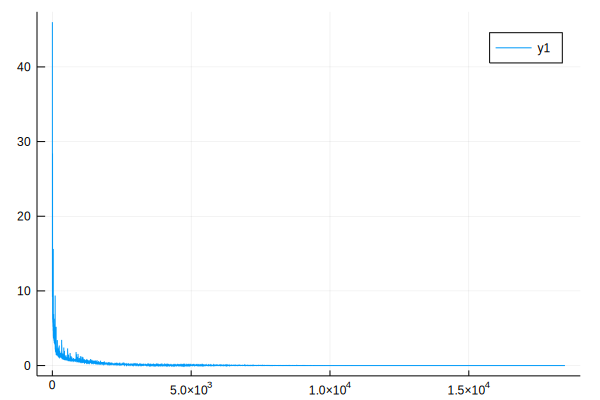

In [11]:
println(size(errs))
# println(errs)
numiters= size(errs)[1]
plot(1:numiters, errs[:,1])

In [12]:
function rand_matsolve(A,B,seed=nothing)
    """
    Helper function that stacks together multiple Ax=b solvers
    INPUT: 
            A: matrix mxn
            B: matrix mxk
    OUTPUT: X: matrix such that AX = B
    """
    
    m1,n = size(A)
    m2,k = size(B)
    sol = zeros(n,k)
    @assert m1==m2
    
    s(b) = rand_linsolve(A,b,I,"coordvec", seed)
    return mapslices(s,B,dims=[1])
    
end

rand_matsolve (generic function with 2 methods)

In [21]:

A = rand(Float64,30,50)
B = rand(Float64,30,60)
Bparam = I # n x n
m1,n = size(A)
m2,k = size(B)
sol = zeros(n,k)

X = rand_matsolve(A,B)
println("done")
println(norm(A * X - B))

done
7.654321725721203e-5


## ADI

Solves $AX - XB = N$ for low rank $N$

In [23]:
function adi(A,B,F,N,p,q)
    m,m2 = size(A)
    n,n2 = size(B)
    
    @assert m==m2
    @assert n==n2
    
    sols = []
    Xprev = zeros((m,n))
    for i = 1:N
        Ahalf = (A - p[i] * I)
        
        
        Bhalf = Xprev * (B - q[i] * I) + F
        
        Xhalf = rand_matsolve(Ahalf,Bhalf)   
        

        Asolve = (B - q[i] * I)
        Bsolve = (A - q[i] * I) * Xhalf - F
        X = (rand_matsolve(Asolve', Bsolve'))'
        Xprev = X 
        push!(sols,X)
    end    
    return sols
end

adi (generic function with 1 method)

In [ ]:
A = rand(Float64,50,50)
B = rand(Float64,30,30)
F = rand(Float64,50,30)
N = 5
p = ones(N)
q = ones(N)

sols = adi(A,B,F,N,p,q)
display("text/plain",sols[end])

X = sols[end]


println(norm(A *X - X * B))


In [ ]:
@time adi(A,B,F,N,p,q)